##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text generation with an RNN

## Setup

### Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
from google.colab import drive

In [ ]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
drive.mount('/content/drive')

Found GPU at: /device:GPU:0
Mounted at /content/drive


### Read the data

First, look in the text:

In [ ]:
# Read, then decode for py2 compat.
path_to_file = '/content/drive/MyDrive/data2/data5.txt'
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 20702 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

મૈકલ પર્વત પર એક નાગ રહેતો હતો. શરીરે તે બળવાન અને લાંબો હતો. આથી તે લાંબો કાળ સુધી સુરક્ષિત રહીને જીવ્યો.

સમય જતાં ઘરડો થયો. હવે તેનામાં શિકાર કરવાની શક્તિ અને ચપળતા ઘટી ગઈ હતી. દાંત પણ તૂટી ગયા હતા. આથી તે ધારેલો શિકાર કરી શકતો ન હતો.

ભૂખ્યો 


In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

67 unique characters


## Process the text

### Vectorize the text

Before training, you need to convert the strings to a numerical representation.

The `tf.keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [ ]:
example_texts = ['કખગઘઙચ', 'સહળ']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'\xe0\xaa\x95', b'\xe0\xaa\x96', b'\xe0\xaa\x97', b'\xe0\xaa\x98',
  b'\xe0\xaa\x99', b'\xe0\xaa\x9a']                                  ,
 [b'\xe0\xaa\xb8', b'\xe0\xaa\xb9', b'\xe0\xaa\xb3']]>

Now create the `tf.keras.layers.StringLookup` layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

It converts from tokens to character IDs:

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[20, 21, 22, 23, 0, 24], [50, 51, 46]]>

Since the goal of this tutorial is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use `tf.keras.layers.StringLookup(..., invert=True)`.  

Note: Here instead of passing the original vocabulary generated with `sorted(set(text))` use the `get_vocabulary()` method of the `tf.keras.layers.StringLookup` layer so that the `[UNK]` tokens is set the same way.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'\xe0\xaa\x95', b'\xe0\xaa\x96', b'\xe0\xaa\x97', b'\xe0\xaa\x98',
  b'[UNK]', b'\xe0\xaa\x9a']                                         ,
 [b'\xe0\xaa\xb8', b'\xe0\xaa\xb9', b'\xe0\xaa\xb3']]>

You can `tf.strings.reduce_join` to join the characters back into strings.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'\xe0\xaa\x95\xe0\xaa\x96\xe0\xaa\x97\xe0\xaa\x98[UNK]\xe0\xaa\x9a',
       b'\xe0\xaa\xb8\xe0\xaa\xb9\xe0\xaa\xb3'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task you're training the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(20702,), dtype=int64, numpy=array([42, 59, 20, ..., 53,  7, 66])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

મ
ૈ
ક
લ
 
પ
ર
્
વ
ત


In [ ]:
seq_length = 100


The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'\xe0\xaa\xae' b'\xe0\xab\x88' b'\xe0\xaa\x95' b'\xe0\xaa\xb2' b' '
 b'\xe0\xaa\xaa' b'\xe0\xaa\xb0' b'\xe0\xab\x8d' b'\xe0\xaa\xb5'
 b'\xe0\xaa\xa4' b' ' b'\xe0\xaa\xaa' b'\xe0\xaa\xb0' b' ' b'\xe0\xaa\x8f'
 b'\xe0\xaa\x95' b' ' b'\xe0\xaa\xa8' b'\xe0\xaa\xbe' b'\xe0\xaa\x97' b' '
 b'\xe0\xaa\xb0' b'\xe0\xaa\xb9' b'\xe0\xab\x87' b'\xe0\xaa\xa4'
 b'\xe0\xab\x8b' b' ' b'\xe0\xaa\xb9' b'\xe0\xaa\xa4' b'\xe0\xab\x8b' b'.'
 b' ' b'\xe0\xaa\xb6' b'\xe0\xaa\xb0' b'\xe0\xab\x80' b'\xe0\xaa\xb0'
 b'\xe0\xab\x87' b' ' b'\xe0\xaa\xa4' b'\xe0\xab\x87' b' ' b'\xe0\xaa\xac'
 b'\xe0\xaa\xb3' b'\xe0\xaa\xb5' b'\xe0\xaa\xbe' b'\xe0\xaa\xa8' b' '
 b'\xe0\xaa\x85' b'\xe0\xaa\xa8' b'\xe0\xab\x87' b' ' b'\xe0\xaa\xb2'
 b'\xe0\xaa\xbe' b'\xe0\xaa\x82' b'\xe0\xaa\xac' b'\xe0\xab\x8b' b' '
 b'\xe0\xaa\xb9' b'\xe0\xaa\xa4' b'\xe0\xab\x8b' b'.' b' ' b'\xe0\xaa\x86'
 b'\xe0\xaa\xa5' b'\xe0\xab\x80' b' ' b'\xe0\xaa\xa4' b'\xe0\xab\x87' b' '
 b'\xe0\xaa\xb2' b'\xe0\xaa\xbe' b'\xe0\xaa\x82' b'\xe0\xaa

It's easier to see what this is doing if you join the tokens back into strings:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'\xe0\xaa\xae\xe0\xab\x88\xe0\xaa\x95\xe0\xaa\xb2 \xe0\xaa\xaa\xe0\xaa\xb0\xe0\xab\x8d\xe0\xaa\xb5\xe0\xaa\xa4 \xe0\xaa\xaa\xe0\xaa\xb0 \xe0\xaa\x8f\xe0\xaa\x95 \xe0\xaa\xa8\xe0\xaa\xbe\xe0\xaa\x97 \xe0\xaa\xb0\xe0\xaa\xb9\xe0\xab\x87\xe0\xaa\xa4\xe0\xab\x8b \xe0\xaa\xb9\xe0\xaa\xa4\xe0\xab\x8b. \xe0\xaa\xb6\xe0\xaa\xb0\xe0\xab\x80\xe0\xaa\xb0\xe0\xab\x87 \xe0\xaa\xa4\xe0\xab\x87 \xe0\xaa\xac\xe0\xaa\xb3\xe0\xaa\xb5\xe0\xaa\xbe\xe0\xaa\xa8 \xe0\xaa\x85\xe0\xaa\xa8\xe0\xab\x87 \xe0\xaa\xb2\xe0\xaa\xbe\xe0\xaa\x82\xe0\xaa\xac\xe0\xab\x8b \xe0\xaa\xb9\xe0\xaa\xa4\xe0\xab\x8b. \xe0\xaa\x86\xe0\xaa\xa5\xe0\xab\x80 \xe0\xaa\xa4\xe0\xab\x87 \xe0\xaa\xb2\xe0\xaa\xbe\xe0\xaa\x82\xe0\xaa\xac\xe0\xab\x8b \xe0\xaa\x95\xe0\xaa\xbe\xe0\xaa\xb3 \xe0\xaa\xb8\xe0\xab\x81\xe0\xaa\xa7\xe0\xab\x80 \xe0\xaa\xb8\xe0\xab\x81\xe0\xaa\xb0\xe0\xaa\x95\xe0\xab\x8d\xe0\xaa\xb7\xe0\xaa\xbf\xe0\xaa\xa4 \xe0\xaa\xb0\xe0\xaa\xb9\xe0\xab\x80\xe0\xaa\xa8\xe0\xab\x87 \xe0\xaa\x9c\xe0\xab\x80'
b'\xe0\xaa\xb5\xe0\xab\x8d

For training you'll need a dataset of `(input, label)` pairs. Where `input` and
`label` are sequences. At each time step the input is the current character and the label is the next character.

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("ટેન્સરફ્લો"))

(['ટ', 'ે', 'ન', '્', 'સ', 'ર', 'ફ', '્', 'લ'],
 ['ે', 'ન', '્', 'સ', 'ર', 'ફ', '્', 'લ', 'ો'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'\xe0\xaa\xae\xe0\xab\x88\xe0\xaa\x95\xe0\xaa\xb2 \xe0\xaa\xaa\xe0\xaa\xb0\xe0\xab\x8d\xe0\xaa\xb5\xe0\xaa\xa4 \xe0\xaa\xaa\xe0\xaa\xb0 \xe0\xaa\x8f\xe0\xaa\x95 \xe0\xaa\xa8\xe0\xaa\xbe\xe0\xaa\x97 \xe0\xaa\xb0\xe0\xaa\xb9\xe0\xab\x87\xe0\xaa\xa4\xe0\xab\x8b \xe0\xaa\xb9\xe0\xaa\xa4\xe0\xab\x8b. \xe0\xaa\xb6\xe0\xaa\xb0\xe0\xab\x80\xe0\xaa\xb0\xe0\xab\x87 \xe0\xaa\xa4\xe0\xab\x87 \xe0\xaa\xac\xe0\xaa\xb3\xe0\xaa\xb5\xe0\xaa\xbe\xe0\xaa\xa8 \xe0\xaa\x85\xe0\xaa\xa8\xe0\xab\x87 \xe0\xaa\xb2\xe0\xaa\xbe\xe0\xaa\x82\xe0\xaa\xac\xe0\xab\x8b \xe0\xaa\xb9\xe0\xaa\xa4\xe0\xab\x8b. \xe0\xaa\x86\xe0\xaa\xa5\xe0\xab\x80 \xe0\xaa\xa4\xe0\xab\x87 \xe0\xaa\xb2\xe0\xaa\xbe\xe0\xaa\x82\xe0\xaa\xac\xe0\xab\x8b \xe0\xaa\x95\xe0\xaa\xbe\xe0\xaa\xb3 \xe0\xaa\xb8\xe0\xab\x81\xe0\xaa\xa7\xe0\xab\x80 \xe0\xaa\xb8\xe0\xab\x81\xe0\xaa\xb0\xe0\xaa\x95\xe0\xab\x8d\xe0\xaa\xb7\xe0\xaa\xbf\xe0\xaa\xa4 \xe0\xaa\xb0\xe0\xaa\xb9\xe0\xab\x80\xe0\xaa\xa8\xe0\xab\x87 \xe0\xaa\x9c'
Target: b'\xe0\xab\x88\xe0\xaa

### Create training batches

You used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Build The Model

This section defines the model as a `keras.Model` subclass (For details see [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)).

This model has three layers:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_training.png?raw=1)

Note: For training you could use a `keras.Sequential` model here. To  generate text later you'll need to manage the RNN's internal state. It's simpler to include the state input and output options upfront, than it is to rearrange the model architecture later. For more details see the [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 68) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [ ]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  17408     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  69700     
                                                                 
Total params: 4,025,412
Trainable params: 4,025,412
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([13,  2, 56, 50, 66, 53, 25, 65, 53, 60,  6,  8, 54, 19, 65, 14, 23,
       21, 46, 61, 14, 26, 50,  1, 20, 58,  7, 42, 36, 36, 45, 28, 26, 66,
       21, 14, 62,  0, 27, 62, 14, 12, 40,  4, 54, 24, 45, 21, 25, 34,  5,
       26,  6, 59,  1, 26, 64, 54, 58, 55, 50, 66, 59, 61,  3, 61, 59, 63,
       66, 67, 22, 67, 11,  6, 10, 33,  7, 54, 56, 41, 65, 14, 57,  0, 25,
       61, 55, 51, 47, 19, 43, 59, 26, 31, 65, 45, 24, 50, 51, 10])

Decode these to see the text predicted by this untrained model:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'\xe0\xaa\xb9\xe0\xaa\xa4\xe0\xab\x81\xe0\xaa\x82. \xe0\xaa\x8f\xe0\xaa\x9f\xe0\xaa\xb2\xe0\xab\x87 \xe0\xaa\x8f \xe0\xaa\xb6\xe0\xaa\x95\xe0\xab\x8d\xe0\xaa\xa4\xe0\xaa\xbf\xe0\xaa\xb6\xe0\xaa\xbe\xe0\xaa\xb3\xe0\xab\x80 \xe0\xaa\xac\xe0\xaa\xa8\xe0\xab\x80 \xe0\xaa\x97\xe0\xaa\xaf\xe0\xab\x8b \xe0\xaa\xb9\xe0\xaa\xa4\xe0\xab\x8b. \xe0\xaa\x8f \xe0\xaa\xa7\xe0\xab\x80\xe0\xaa\xb0\xe0\xab\x87\xe0\xaa\xa5\xe0\xab\x80 \xe0\xaa\xb8\xe0\xaa\xb0\xe0\xaa\x95\xe0\xab\x80\xe0\xaa\xa8\xe0\xab\x87 \xe0\xaa\x9a\xe0\xaa\xbe\xe0\xaa\xb2\xe0\xab\x8d\xe0\xaa\xaf\xe0\xab\x8b \xe0\xaa\x97\xe0\xaa\xaf\xe0\xab\x8b.\r\n\r\n\xe0\xaa\xa6\xe0\xab\x87\xe0\xaa\xa1\xe0\xaa\x95\xe0\xaa\xbe\xe0\xaa\x82\xe0\xaa\xa8\xe0\xab\x8b \xe0\xaa\xb0\xe0\xaa\xbe\xe0\xaa\x9c\xe0\xaa\xbe \xe0\xaa\x9b\xe0\xaa\xbe\xe0\xaa\xa8\xe0\xab\x8b\xe0\xaa\xae\xe0\xaa\xbe\xe0\xaa\xa8\xe0\xab\x8b \xe0\xaa\xa4\xe0\xab\x87\xe0\xaa\xa8\xe0\xab\x80 \xe0\xaa\x97\xe0\xaa\xa4\xe0\xaa\xbf\xe0\xaa\xb5\xe0\xaa\xbf'

Next Char Predictions:
 b

## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the `from_logits` flag.


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 68)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.218841, shape=(), dtype=float32)


A newly initialized model shouldn't be too sure of itself, the output logits should all have similar magnitudes. To confirm this you can check that the exponential of the mean loss is approximately equal to the vocabulary size. A much higher loss means the model is sure of its wrong answers, and is badly initialized:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

67.95468

Configure the training procedure using the `tf.keras.Model.compile` method. Use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [ ]:
model.compile(optimizer='adam', loss=loss,metrics=['accuracy'])

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [ ]:
EPOCHS = 30

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
3/3 [==============================] - 3s 236ms/step - loss: 4.1768 - accuracy: 0.1263
Epoch 2/30
3/3 [==============================] - 0s 121ms/step - loss: 5.1769 - accuracy: 0.1812
Epoch 3/30
3/3 [==============================] - 1s 276ms/step - loss: 4.0397 - accuracy: 0.1968
Epoch 4/30
3/3 [==============================] - 0s 123ms/step - loss: 4.0753 - accuracy: 0.2357
Epoch 5/30
3/3 [==============================] - 1s 624ms/step - loss: 4.0603 - accuracy: 0.2547
Epoch 6/30
3/3 [==============================] - 0s 171ms/step - loss: 4.0246 - accuracy: 0.2588
Epoch 7/30
3/3 [==============================] - 1s 124ms/step - loss: 3.9650 - accuracy: 0.2507
Epoch 8/30
3/3 [==============================] - 0s 131ms/step - loss: 3.8564 - accuracy: 0.2368
Epoch 9/30
3/3 [==============================] - 0s 119ms/step - loss: 3.6151 - accuracy: 0.2285
Epoch 10/30
3/3 [==============================] - 0s 129ms/step - loss: 3.3722 - accuracy: 0.2198
Epoch 11/30
3/3 [==

## Generate text

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

![To generate text the model's output is fed back to the input](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_sampling.png?raw=1)

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.


The following makes a single step prediction:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['થોડી વાર થઈ'])
result = [next_char]

for n in range(40):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

થોડી વાર થઈશીને આત મિત જમું જો ! તી, એન પહળારી જાની 

________________________________________________________________________________

Run time: 0.11966633796691895


The easiest thing you can do to improve the results is to train it for longer (try `EPOCHS = 30`).

You can also experiment with a different start string, try adding another RNN layer to improve the model's accuracy, or adjust the temperature parameter to generate more or less random predictions.

If you want the model to generate text *faster* the easiest thing you can do is batch the text generation. In the example below the model generates 5 outputs in about the same time it took to generate 1 above.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ઉત્તર', 'લગભગ', 'રાજ્યમાં', 'દરમિયાન', 'સમય'])
result = [next_char]

for n in range(40):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
for i in range(5):
  print(result[i].numpy().decode('utf-8'), '\n\n' + '_'*20)

ઉત્તર જેના પ્રથમ અર્થ ભારતીય રાજસ્થાનો સૌથી પ 

____________________
લગભગ] કોતરકામ, રાણકાર અને કિલ્લાના વ્યક્તિગત 

____________________
રાજ્યમાંથી મકાન અમૂરી પુનઃસ્થાપિત કરે છે. આ પ્રક 

____________________
દરમિયાન હેરાન નું વારસાગત રીતે લૂંટી શીખ તરીકે  

____________________
સમયe અધિકારીઓની પૂછપરછ્ઠી અવિચ્ચિત છે, જેના 

____________________


## Export the generator

This single-step model can easily be [saved and restored](https://www.tensorflow.org/guide/saved_model), allowing you to use it anywhere a `tf.saved_model` is accepted.

In [ ]:
model.save('/content/drive/MyDrive/RNN/data2', save_format='tf')



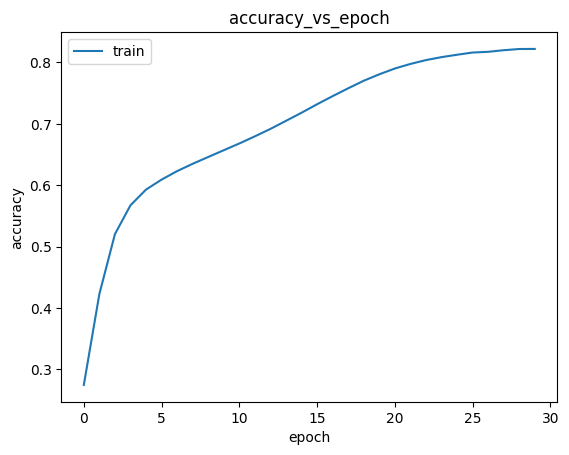

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
history.history.keys()
plt.plot(history.history['accuracy'])
plt.title('accuracy_vs_epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()
plt.savefig('rnn_accuracy_graph_data2.png')

In [ ]:
states = None
next_char = tf.constant(['દાવપેચ'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

NameError: ignored

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.
It uses teacher-forcing which prevents bad predictions from being fed back to the model, so the model never learns to recover from mistakes.

So now that you've seen how to run the model manually next you'll implement the training loop. This gives a starting point if, for example, you want to implement _curriculum  learning_ to help stabilize the model's open-loop output.

The most important part of a custom training loop is the train step function.

Use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The basic procedure is:

1. Execute the model and calculate the loss under a `tf.GradientTape`.
2. Calculate the updates and apply them to the model using the optimizer.

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above implementation of the `train_step` method follows [Keras' `train_step` conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). This is optional, but it allows you to change the behavior of the train step and still use keras' `Model.compile` and `Model.fit` methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

Or if you need more control, you can write your own complete custom training loop:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))